In [1]:
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [368]:
from sklearn.model_selection import train_test_split, StratifiedKFold,\
    GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBClassifier

from sklearn.metrics import precision_score, recall_score, auc, accuracy_score,\
roc_auc_score, f1_score, log_loss, classification_report,\
roc_curve, confusion_matrix, mean_squared_error

In [3]:
sns.set(rc={'figure.figsize':(8.5, 6.0)})

# Load Data

In [4]:
!unzip spaceship-titanic.zip

Archive:  spaceship-titanic.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [32]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv('test.csv')
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [33]:
types = train_data.dtypes

In [45]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


# Data Analysis

In [35]:
train_data.Transported.value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

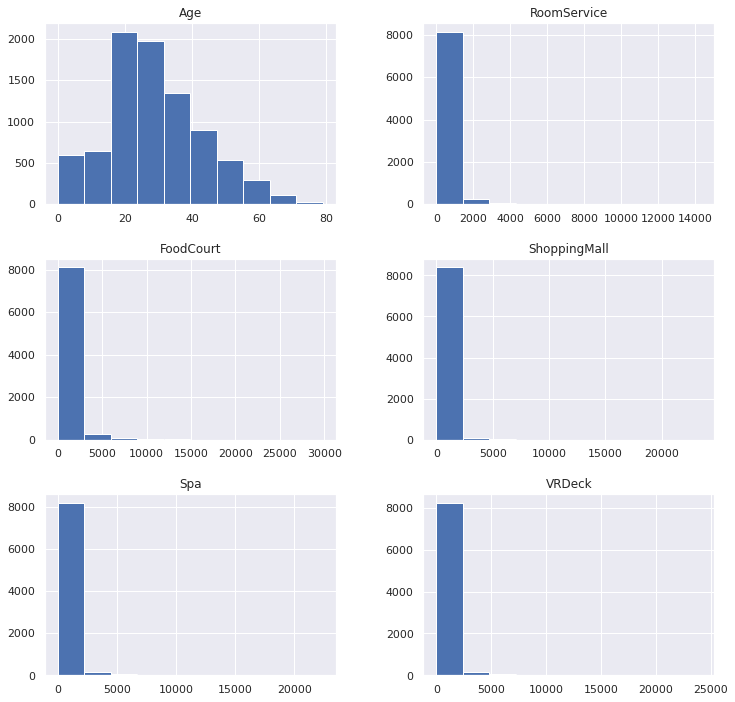

In [36]:
train_data.hist(figsize=(12, 12));

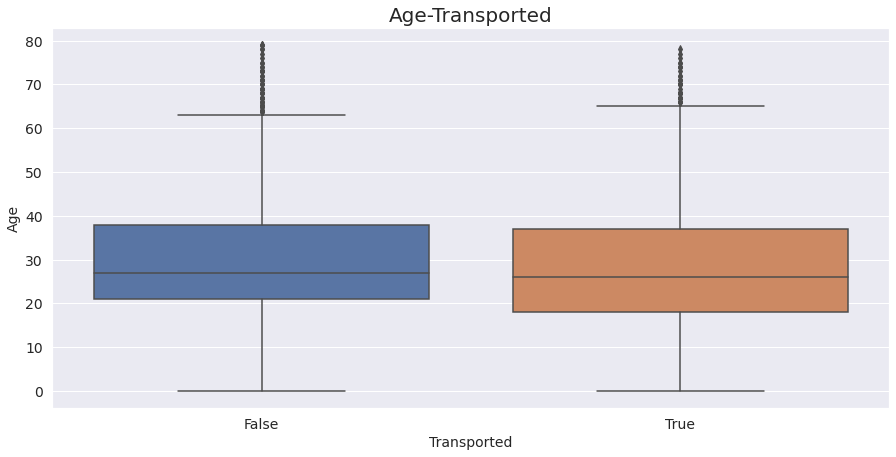

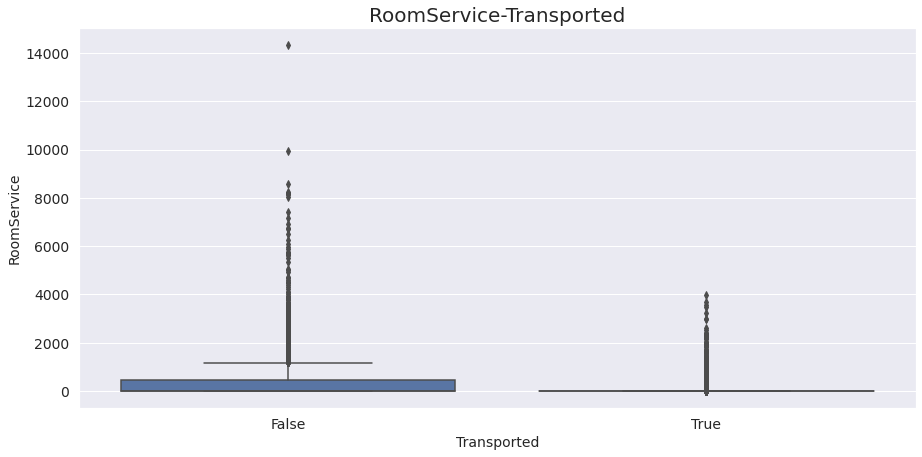

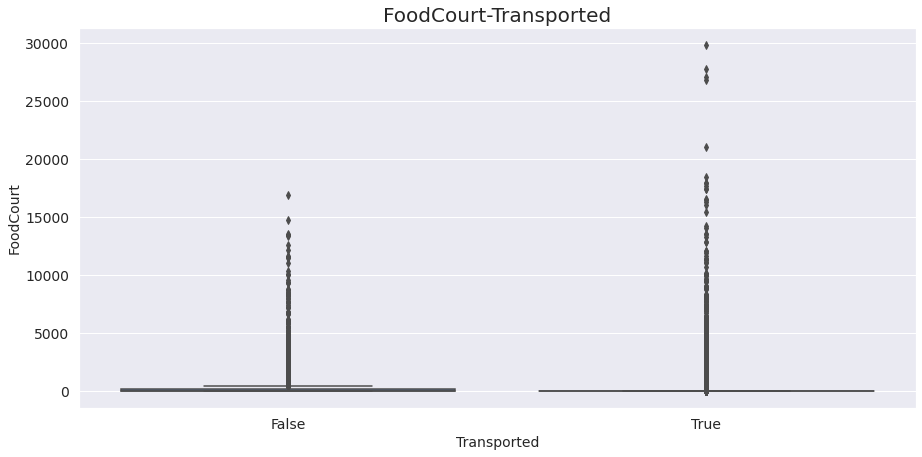

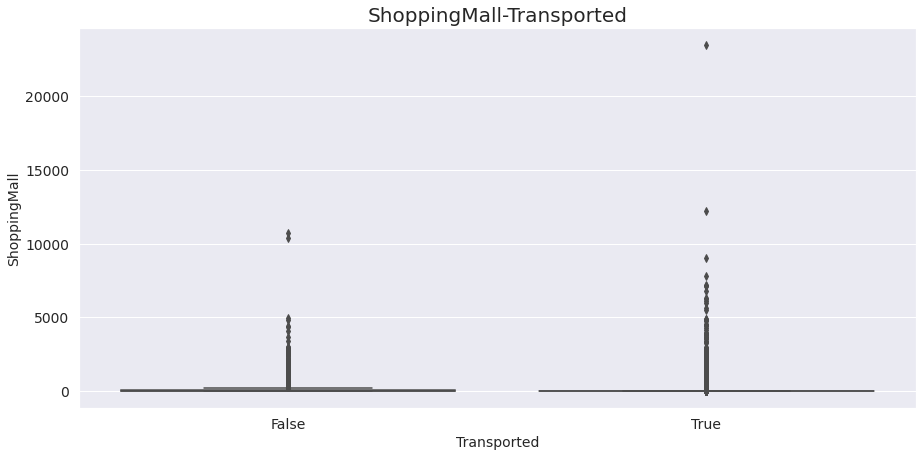

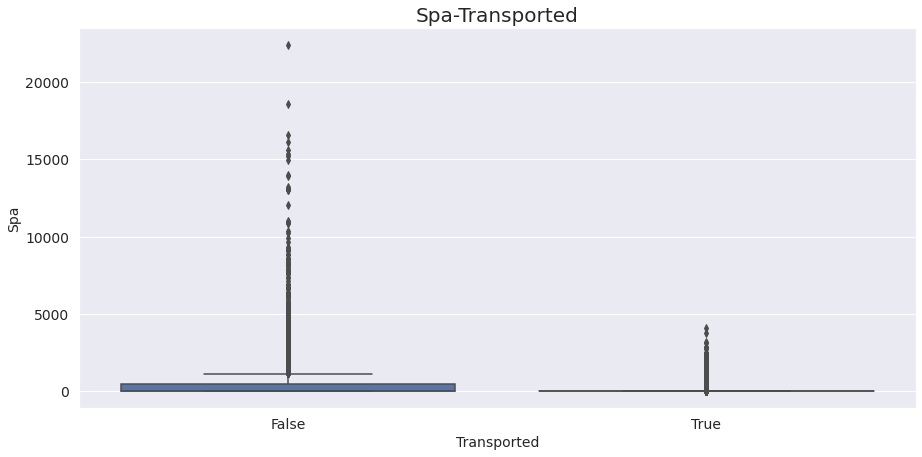

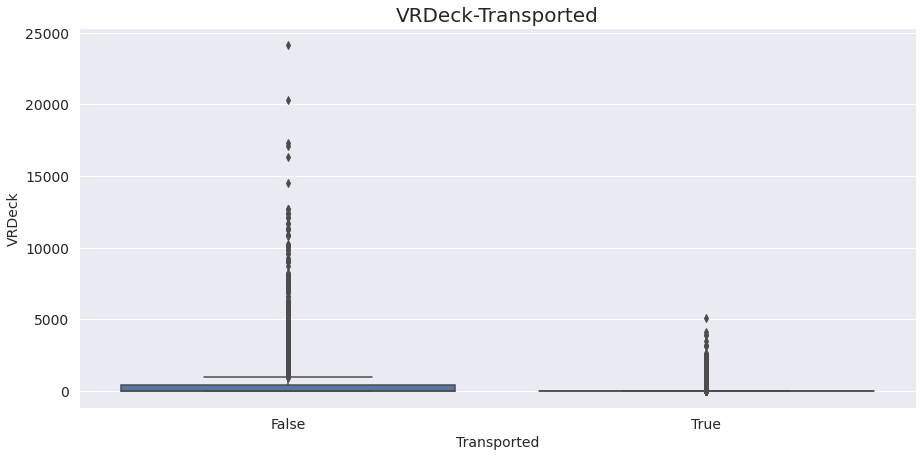

In [37]:
for c in types[types == 'float64'].index:
    plt.figure(figsize=(15, 7))

    sns.boxplot(x='Transported', y=c, data=train_data)

    plt.title(f'{c}-Transported', fontsize=20)
    plt.ylabel(c, fontsize=14)
    plt.xlabel('Transported', fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.plot();

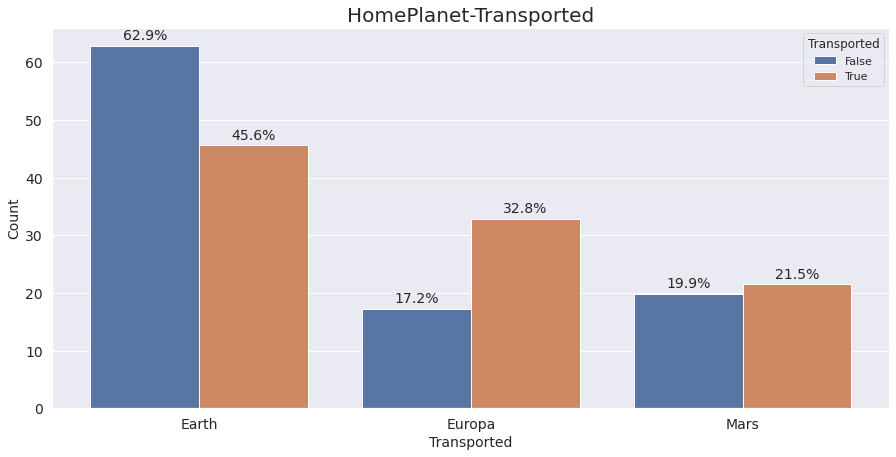

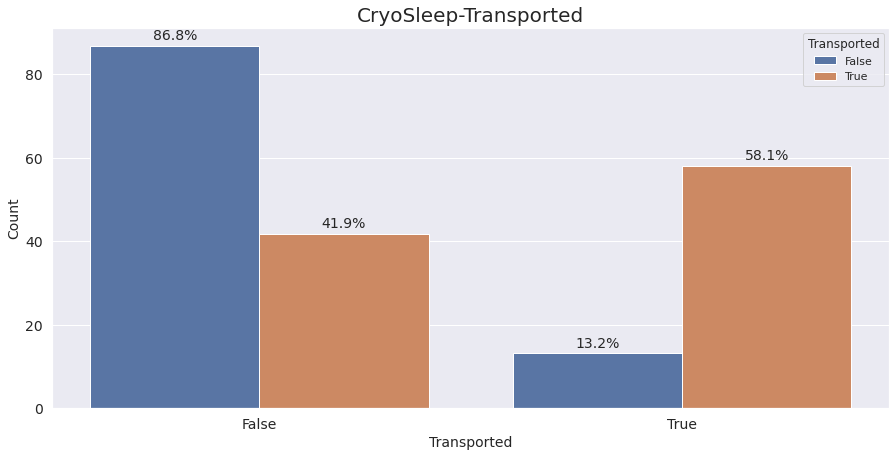

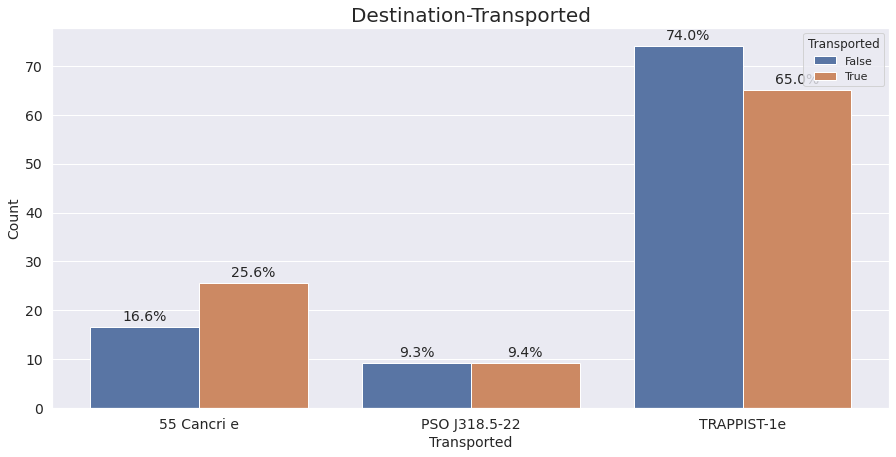

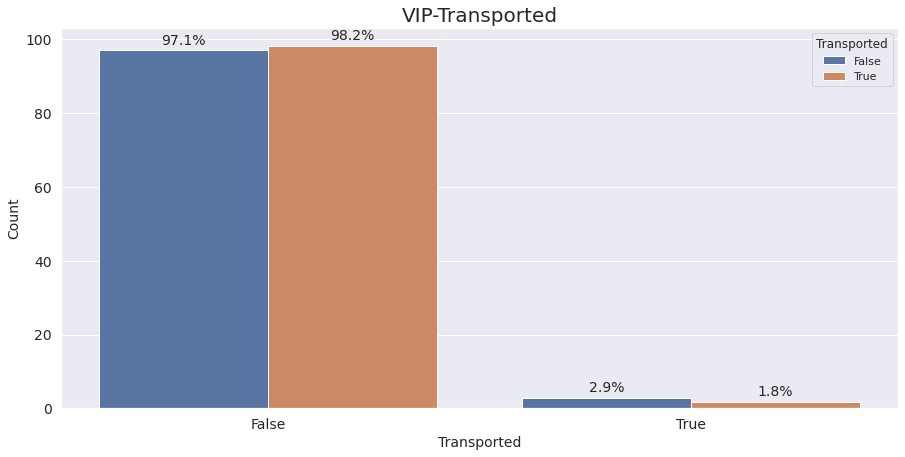

In [44]:
for c in types[types == 'object'].index:
    if c in ['PassengerId', 'Name', 'Cabin']:
        continue

    plt.figure(figsize=(15, 7))

    educ_def = (train_data.groupby(['Transported'])[c]
                .value_counts(normalize=True)
                .rename('percentage')
                .mul(100)
                .reset_index()
                .sort_values(c))

    ax = sns.barplot(x=c, y="percentage", hue="Transported", data=educ_def)

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(percentage,  # текст
                    (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                    ha='center',  # центрирование
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points',  # точка смещения относительно координаты
                    fontsize=14)

    plt.title(f'{c}-Transported', fontsize=20)
    plt.ylabel('Count', fontsize=14)
    plt.xlabel('Transported', fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.plot();

# Feature Engineering

In [46]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [47]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [323]:
def create_features(dataset, is_train=True, is_log=True):
    homeplanet_ = dataset.HomePlanet.fillna(dataset.HomePlanet.mode()[0])
    cryo_sleap_ = dataset.CryoSleep.fillna(dataset.CryoSleep.mode()[0]).map(
        {np.bool_(True): 1, np.bool_(False): 0}
    )
    cabin_ = dataset.Cabin.str.split('/', expand=True)
    cabin_.columns = ['DeckCabin', 'NumCabin', 'SideCabin']
    cabin_skip_ = ~train_data.Cabin.notnull()

    cabin_.SideCabin.fillna(cabin_.SideCabin.mode()[0], inplace=True)
    cabin_.SideCabin = cabin_.SideCabin.map({'S': 1, 'P': 0})
    cabin_ = pd.concat([pd.get_dummies(cabin_.DeckCabin, prefix="DeckCabin"), cabin_],
                      axis=1)
    cabin_.drop(columns=['NumCabin', 'DeckCabin'], axis=1, inplace=True)

    destination_ = dataset.Destination.fillna(dataset.Destination.mode()[0])
    vip_ = dataset.VIP.fillna(dataset.VIP.mode()[0])

    

    dataset_temp = pd.concat([pd.get_dummies(homeplanet_, prefix="HomePlanet"),
                              cryo_sleap_,
                              cabin_,
                              pd.DataFrame({'CabinSkip': ~dataset.Cabin.notnull()}),
                              vip_,
                              pd.get_dummies(destination_, prefix="Destination"),
                              dataset[['Age', 'RoomService', 'FoodCourt',
                                      'ShoppingMall', 'Spa', 'VRDeck']]
                              ],
                      axis=1)
    
    dataset_temp.Age.fillna(dataset_temp.Age.median(), inplace=True)
    dataset_temp.RoomService.fillna(dataset_temp.RoomService.median(), inplace=True)
    dataset_temp.FoodCourt.fillna(dataset_temp.FoodCourt.median(), inplace=True)
    dataset_temp.ShoppingMall.fillna(dataset_temp.ShoppingMall.median(), inplace=True)
    dataset_temp.Spa.fillna(dataset_temp.Spa.median(), inplace=True)
    dataset_temp.VRDeck.fillna(dataset_temp.VRDeck.median(), inplace=True)


    for c in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
        dataset_temp[c] = np.log(dataset_temp[c] + 1)

    if is_train:
        return dataset_temp, dataset['Transported']
    else:
        return dataset_temp

In [324]:
x_data, t_data = create_features(train_data, is_train=True, is_log=True)
x_test = create_features(test_data, is_train=False, is_log=True)

In [325]:
x_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   HomePlanet_Earth           8693 non-null   uint8  
 1   HomePlanet_Europa          8693 non-null   uint8  
 2   HomePlanet_Mars            8693 non-null   uint8  
 3   CryoSleep                  8693 non-null   int64  
 4   DeckCabin_A                8693 non-null   uint8  
 5   DeckCabin_B                8693 non-null   uint8  
 6   DeckCabin_C                8693 non-null   uint8  
 7   DeckCabin_D                8693 non-null   uint8  
 8   DeckCabin_E                8693 non-null   uint8  
 9   DeckCabin_F                8693 non-null   uint8  
 10  DeckCabin_G                8693 non-null   uint8  
 11  DeckCabin_T                8693 non-null   uint8  
 12  SideCabin                  8693 non-null   int64  
 13  CabinSkip                  8693 non-null   bool 

# Modeling

## Logit baseline

In [326]:
scaler = StandardScaler()
scaler.fit(x_data)
x_data_scl = scaler.transform(x_data)

In [327]:
x_train, x_valid, t_train, t_valid = train_test_split(
    x_data_scl, t_data, test_size=0.15, stratify=t_data, shuffle=True, random_state=5)

In [328]:
logit = LogisticRegression(class_weight='balanced')
logit.fit(x_train, t_train)

t_pred = logit.predict(x_valid)
t_score = logit.predict_proba(x_valid)[:, 1]

In [329]:
print('accuracy:', accuracy_score(t_valid, t_pred))
print('roc-auc:', roc_auc_score(t_valid, t_score))
print('precision:', precision_score(t_valid, t_pred))
print('recall:', recall_score(t_valid, t_pred))
print('f1:', f1_score(t_valid, t_pred))

accuracy: 0.7829754601226994
roc-auc: 0.8631066225336937
precision: 0.7807807807807807
recall: 0.791476407914764
f1: 0.7860922146636431


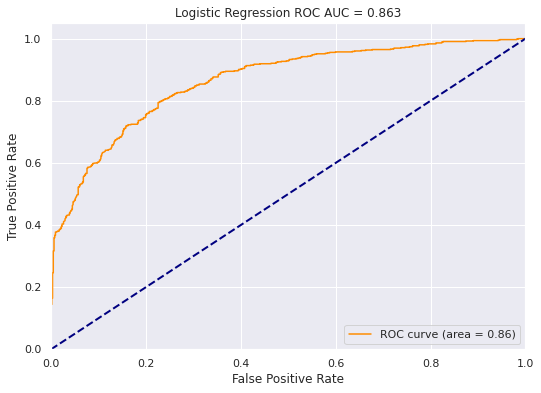

In [330]:
fpr, tpr, thresholds = roc_curve(t_valid, t_score)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [178]:
def create_submit(model, x_test):
    df_submit = pd.read_csv("sample_submission.csv")
    df_submit.Transported = model.predict(np.array(x_test))
    df_submit.to_csv('submit_spaceship_titanic.csv', index=False)

In [179]:
create_submit(logit, scaler.transform(x_test))

## RF

In [345]:
x_train, x_valid, t_train, t_valid = train_test_split(
    np.array(x_data), np.array(t_data), test_size=0.15, stratify=np.array(t_data), shuffle=True, random_state=5)

In [346]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(x_train, t_train)

t_pred = rf.predict(x_valid)
t_score = rf.predict_proba(x_valid)[:, 1]

In [347]:
print('accuracy:', accuracy_score(t_valid, t_pred))
print('roc-auc:', roc_auc_score(t_valid, t_score))
print('precision:', precision_score(t_valid, t_pred))
print('recall:', recall_score(t_valid, t_pred))
print('f1:', f1_score(t_valid, t_pred))

accuracy: 0.8013803680981595
roc-auc: 0.8873009487648178
precision: 0.8305647840531561
recall: 0.76103500761035
f1: 0.7942811755361397


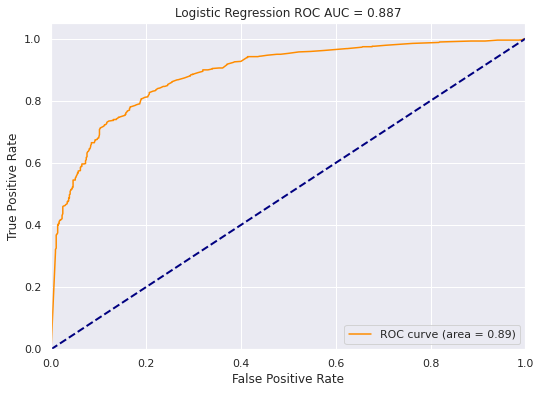

In [348]:
fpr, tpr, thresholds = roc_curve(t_valid, t_score)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

Feature ranking:
1. Age 0.176208 
2. Spa 0.122705 
3. RoomService 0.115027 
4. VRDeck 0.110292 
5. FoodCourt 0.105829 
6. CryoSleep 0.101032 
7. ShoppingMall 0.096542 
8. HomePlanet_Earth 0.023480 
9. SideCabin 0.021414 
10. HomePlanet_Europa 0.020364 
11. DeckCabin_F 0.016156 
12. DeckCabin_E 0.015230 
13. DeckCabin_G 0.012030 
14. HomePlanet_Mars 0.011071 
15. Destination_TRAPPIST-1e 0.009438 
16. Destination_55 Cancri e 0.009396 
17. DeckCabin_C 0.007587 
18. DeckCabin_B 0.006888 
19. Destination_PSO J318.5-22 0.006319 
20. DeckCabin_D 0.004255 
21. CabinSkip 0.003148 
22. VIP 0.003075 
23. DeckCabin_A 0.002420 
24. DeckCabin_T 0.000094 


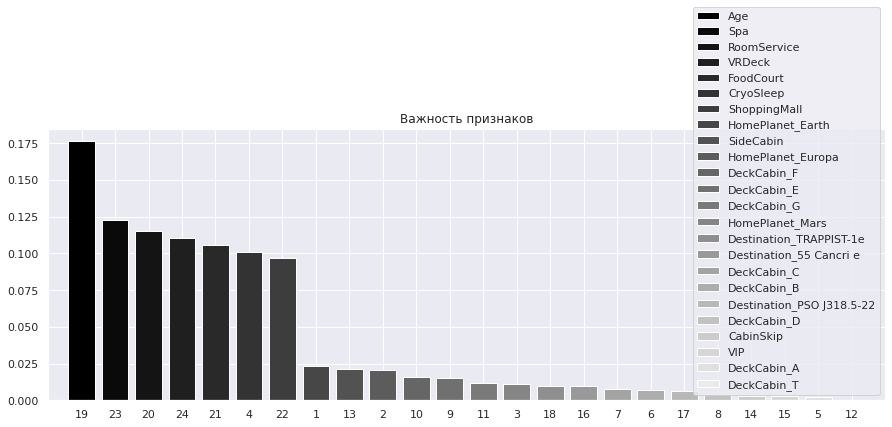

In [349]:
features = {}
for i in range(1, x_data.shape[1] + 1):
    features[f"f{i}"] = x_data.columns[i - 1]

importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = importances.shape[0]
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print(
        "%d. %s %f "
        % (f + 1, features["f" + str(feature_indices[f])], importances[indices[f]])
    )
plt.figure(figsize=(15, 5))
plt.title(u"Важность признаков")
bars = plt.bar(
    range(num_to_plot),
    importances[indices[:num_to_plot]],
    color=([str(i / float(num_to_plot + 1)) for i in range(num_to_plot)]),
    align="center",
)
ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices]);

In [350]:
create_submit(rf, np.array(x_test))

## rf + cv

In [336]:
x_train, x_valid, t_train, t_valid = train_test_split(
    np.array(x_data), np.array(t_data), test_size=0.15, stratify=np.array(t_data), shuffle=True, random_state=5)

In [337]:
parameters_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 3],
    'n_estimators': np.arange(50, 350, 50)
}

rf_cv = RandomForestClassifier(class_weight='balanced')
cv = StratifiedKFold(n_splits=5, shuffle=True)
grid_cv = GridSearchCV(rf_cv, parameters_grid,
                       scoring='roc_auc', cv=cv, verbose=1)

In [338]:
%%time
grid_cv.fit(x_train, t_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: user 3min 37s, sys: 730 ms, total: 3min 37s
Wall time: 3min 39s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5], 'min_samples_split': [2, 3],
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300])},
             scoring='roc_auc', verbose=1)

In [339]:
grid_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_split': 2,
 'n_estimators': 250}

In [340]:
rf = RandomForestClassifier(**grid_cv.best_params_, class_weight='balanced')
rf.fit(x_train, t_train)

t_pred = rf.predict(x_valid)
t_score = rf.predict_proba(x_valid)[:, 1]

In [341]:
print('accuracy:', accuracy_score(t_valid, t_pred))
print('roc-auc:', roc_auc_score(t_valid, t_score))
print('precision:', precision_score(t_valid, t_pred))
print('recall:', recall_score(t_valid, t_pred))
print('f1:', f1_score(t_valid, t_pred))

accuracy: 0.7684049079754601
roc-auc: 0.8716873804633963
precision: 0.808695652173913
recall: 0.7077625570776256
f1: 0.7548701298701299


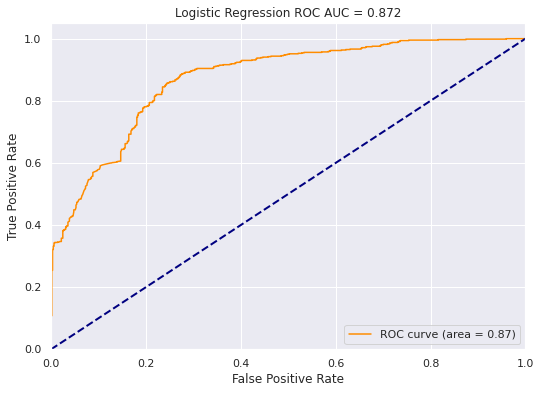

In [342]:
fpr, tpr, thresholds = roc_curve(t_valid, t_score)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

Feature ranking:
1. CryoSleep 0.239218 
2. VRDeck 0.132919 
3. Spa 0.125381 
4. RoomService 0.124668 
5. ShoppingMall 0.076682 
6. FoodCourt 0.076340 
7. HomePlanet_Earth 0.048603 
8. HomePlanet_Europa 0.041633 
9. Age 0.023180 
10. DeckCabin_G 0.019902 
11. DeckCabin_B 0.017692 
12. HomePlanet_Mars 0.014587 
13. DeckCabin_F 0.014467 
14. DeckCabin_E 0.010984 
15. DeckCabin_C 0.010760 
16. Destination_55 Cancri e 0.007121 
17. SideCabin 0.006912 
18. Destination_TRAPPIST-1e 0.003345 
19. Destination_PSO J318.5-22 0.001711 
20. DeckCabin_D 0.001513 
21. VIP 0.000847 
22. DeckCabin_A 0.000812 
23. CabinSkip 0.000693 
24. DeckCabin_T 0.000030 


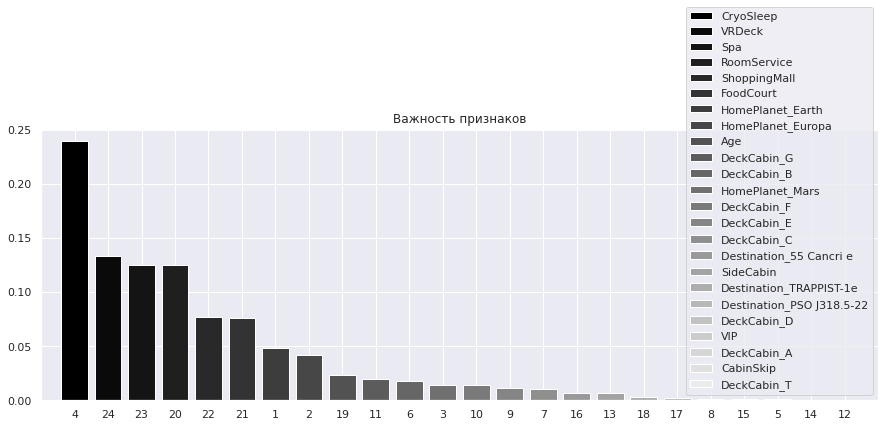

In [343]:
features = {}
for i in range(1, x_data.shape[1] + 1):
    features[f"f{i}"] = x_data.columns[i - 1]

importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = importances.shape[0]
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print(
        "%d. %s %f "
        % (f + 1, features["f" + str(feature_indices[f])], importances[indices[f]])
    )
plt.figure(figsize=(15, 5))
plt.title(u"Важность признаков")
bars = plt.bar(
    range(num_to_plot),
    importances[indices[:num_to_plot]],
    color=([str(i / float(num_to_plot + 1)) for i in range(num_to_plot)]),
    align="center",
)
ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices]);

In [344]:
create_submit(rf, np.array(x_test))

## XGBoost

In [374]:
x_train, x_valid, t_train, t_valid = train_test_split(
    np.array(x_data), np.array(t_data), test_size=0.15, stratify=np.array(t_data), shuffle=True, random_state=5)

In [375]:
xgb = XGBClassifier(class_weight='balanced')
xgb.fit(x_train, t_train)

t_pred = xgb.predict(x_valid)
t_score = xgb.predict_proba(x_valid)[:, 1]

In [376]:
print('accuracy:', accuracy_score(t_valid, t_pred))
print('roc-auc:', roc_auc_score(t_valid, t_score))
print('precision:', precision_score(t_valid, t_pred))
print('recall:', recall_score(t_valid, t_pred))
print('f1:', f1_score(t_valid, t_pred))

accuracy: 0.8151840490797546
roc-auc: 0.8924952773484456
precision: 0.7979942693409742
recall: 0.84779299847793
f1: 0.822140221402214


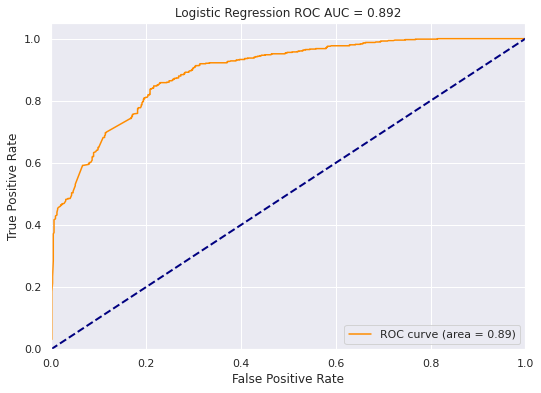

In [377]:
fpr, tpr, thresholds = roc_curve(t_valid, t_score)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

Feature ranking:
1. CryoSleep 0.483135 
2. DeckCabin_G 0.084583 
3. HomePlanet_Earth 0.074223 
4. HomePlanet_Europa 0.066050 
5. RoomService 0.042684 
6. Spa 0.037342 
7. VRDeck 0.029040 
8. DeckCabin_E 0.024016 
9. FoodCourt 0.022301 
10. HomePlanet_Mars 0.021516 
11. Age 0.018728 
12. SideCabin 0.013778 
13. ShoppingMall 0.013404 
14. DeckCabin_F 0.013399 
15. DeckCabin_C 0.013280 
16. Destination_55 Cancri e 0.011263 
17. DeckCabin_B 0.009985 
18. DeckCabin_A 0.009934 
19. VIP 0.005035 
20. Destination_TRAPPIST-1e 0.004519 
21. Destination_PSO J318.5-22 0.001785 
22. DeckCabin_D 0.000000 
23. CabinSkip 0.000000 
24. DeckCabin_T 0.000000 


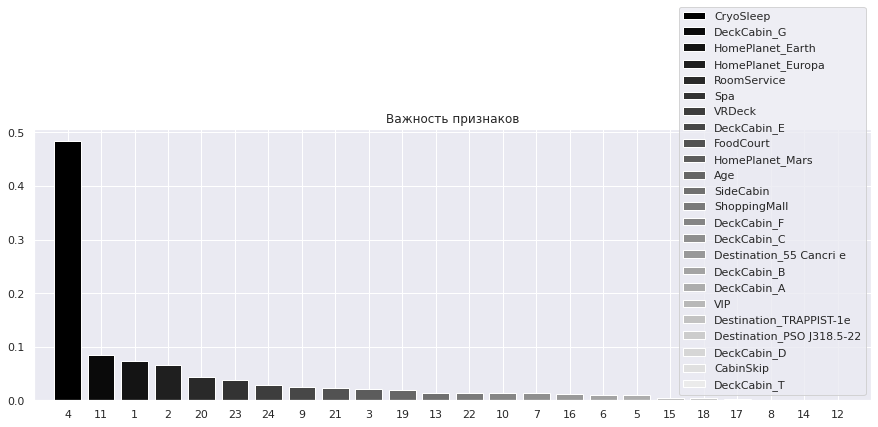

In [378]:
features = {}
for i in range(1, x_data.shape[1] + 1):
    features[f"f{i}"] = x_data.columns[i - 1]

importances = xgb.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = importances.shape[0]
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print(
        "%d. %s %f "
        % (f + 1, features["f" + str(feature_indices[f])], importances[indices[f]])
    )
plt.figure(figsize=(15, 5))
plt.title(u"Важность признаков")
bars = plt.bar(
    range(num_to_plot),
    importances[indices[:num_to_plot]],
    color=([str(i / float(num_to_plot + 1)) for i in range(num_to_plot)]),
    align="center",
)
ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices]);

In [379]:
create_submit(xgb, np.array(x_test))

## XGBoost + CV

In [390]:
x_train, x_valid, t_train, t_valid = train_test_split(
    np.array(x_data), np.array(t_data), test_size=0.15, stratify=np.array(t_data), shuffle=True, random_state=5)

In [391]:
params = {
    'reg_lambda': np.linspace(1, 100, 5),
    'n_estimators': np.arange(100, 250, 50),
    'learning_rate': np.linspace(0.1, 0.001, 5),
    'max_depth': [3, 4, 5]
}

model_xgb_cv = XGBClassifier(class_weight='balanced')
cv = StratifiedKFold(n_splits=5, shuffle=True)
model_cv = GridSearchCV(model_xgb_cv, params, scoring='roc_auc', cv=cv)

In [392]:
model_cv.fit(x_train, t_train)
model_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 150,
 'reg_lambda': 25.75}

In [393]:
xgb = XGBClassifier(**model_cv.best_params_, class_weight='balanced')
xgb.fit(x_train, t_train)

t_pred = xgb.predict(x_valid)
t_score = xgb.predict_proba(x_valid)[:, 1]

In [394]:
print('accuracy:', accuracy_score(t_valid, t_pred))
print('roc-auc:', roc_auc_score(t_valid, t_score))
print('precision:', precision_score(t_valid, t_pred))
print('recall:', recall_score(t_valid, t_pred))
print('f1:', f1_score(t_valid, t_pred))

accuracy: 0.8197852760736196
roc-auc: 0.9017806101924584
precision: 0.8049132947976878
recall: 0.84779299847793
f1: 0.8257968865826537


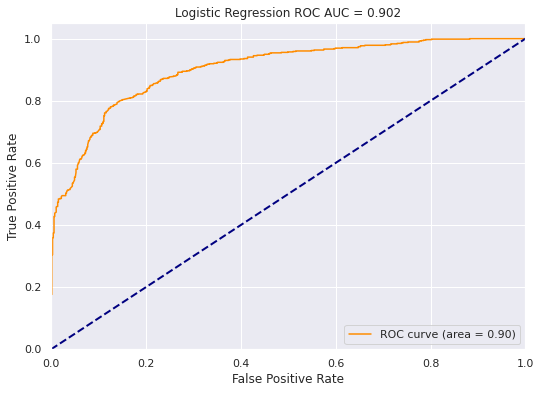

In [395]:
fpr, tpr, thresholds = roc_curve(t_valid, t_score)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

Feature ranking:
1. CryoSleep 0.652436 
2. HomePlanet_Earth 0.071561 
3. DeckCabin_G 0.040845 
4. HomePlanet_Europa 0.026951 
5. RoomService 0.026753 
6. VRDeck 0.023236 
7. Spa 0.022857 
8. ShoppingMall 0.015077 
9. DeckCabin_E 0.014966 
10. FoodCourt 0.014136 
11. DeckCabin_F 0.013134 
12. Destination_55 Cancri e 0.010837 
13. SideCabin 0.009915 
14. HomePlanet_Mars 0.009605 
15. DeckCabin_C 0.008803 
16. DeckCabin_A 0.007958 
17. Age 0.007711 
18. Destination_TRAPPIST-1e 0.005004 
19. DeckCabin_B 0.004807 
20. Destination_PSO J318.5-22 0.004239 
21. DeckCabin_D 0.004009 
22. VIP 0.002587 
23. CabinSkip 0.002573 
24. DeckCabin_T 0.000000 


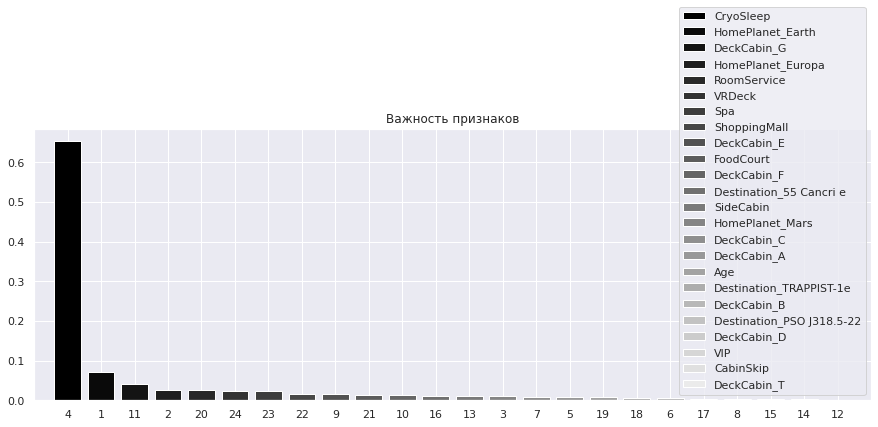

In [396]:
features = {}
for i in range(1, x_data.shape[1] + 1):
    features[f"f{i}"] = x_data.columns[i - 1]

importances = xgb.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = importances.shape[0]
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print(
        "%d. %s %f "
        % (f + 1, features["f" + str(feature_indices[f])], importances[indices[f]])
    )
plt.figure(figsize=(15, 5))
plt.title(u"Важность признаков")
bars = plt.bar(
    range(num_to_plot),
    importances[indices[:num_to_plot]],
    color=([str(i / float(num_to_plot + 1)) for i in range(num_to_plot)]),
    align="center",
)
ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices]);

In [398]:
create_submit(xgb, np.array(x_test))